In [6]:
# basic
import pandas as pd
import numpy as np
import ast
import json
import os

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#pearson
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [7]:
# convert string to dictionary
def to_dict(attribute):
    try:
        if attribute != None:
            return ast.literal_eval(attribute)
        else:
            return ast.literal_eval("{}")
    except Exception as ex:
        print(ex)

In [8]:
# importing restaurants
restaurant = pd.read_csv('final_restaurant.csv')

In [9]:
# expand out attributes and make them their own columns
restaurant['attributes'] = restaurant['attributes'].replace(r'^\s*$', np.nan, regex=True)
restaurant['attributes'] = restaurant['attributes'].where(pd.notnull(restaurant['attributes']), None)
attributes_dict = [to_dict(x) for x in restaurant['attributes']]
attributes = pd.DataFrame(attributes_dict)

pd.set_option('display.max_columns', None)

KeyError: 'attributes'

In [ ]:
# expand out nested dictionaries like GoodForMeal and Ambience
attributes['GoodForMeal'] = attributes['GoodForMeal'].where(pd.notnull(attributes['GoodForMeal']), None)
gfm_dict = [to_dict(x) for x in attributes['GoodForMeal']]
gfm = pd.json_normalize(gfm_dict)
# print(gfm)

attributes['Ambience'] = attributes['Ambience'].where(pd.notnull(attributes['Ambience']), None)
a_dict = [to_dict(x) for x in attributes['Ambience']]
a = pd.json_normalize(a_dict)
# print(a)

attributes['BusinessParking'] = attributes['BusinessParking'].where(pd.notnull(attributes['BusinessParking']), None)
bp_dict = [to_dict(x) for x in attributes['BusinessParking']]
bp = pd.json_normalize(bp_dict)
# print(bp)

attributes['BestNights'] = attributes['BestNights'].where(pd.notnull(attributes['BestNights']), None)
bn_dict = [to_dict(x) for x in attributes['BestNights']]
bn = pd.json_normalize(bn_dict)
bn = bn.rename(columns={'monday': 'monday_bn', 'tuesday': 'tuesday_bn', 
                        'wednesday': 'wednesday_bn', 'thursday': 'thursday_bn', 
                        'friday': 'friday_bn', 'saturday': 'saturday_bn', 'sunday': 'sunday_bn'})
# print(bn)

attributes['Music'] = attributes['Music'].where(pd.notnull(attributes['Music']), None)
m_dict = [to_dict(x) for x in attributes['Music']]
m = pd.json_normalize(m_dict)
# print(m)

attributes['DietaryRestrictions'] = attributes['DietaryRestrictions'].where(pd.notnull(attributes['DietaryRestrictions']), None)
dr_dict = [to_dict(x) for x in attributes['DietaryRestrictions']]
dr = pd.json_normalize(dr_dict)
# print(dr)

# drop col in attributes
attributes = attributes.drop(['GoodForMeal', 'Ambience', 'BusinessParking', 'BestNights', 'Music', 'DietaryRestrictions'], 
                             axis=1)

# fuse together
attributes = pd.concat([attributes, gfm, a, bp, bn, m, dr], axis=1)

attributes

In [ ]:
# one hot encode attributes
df = pd.get_dummies(attributes)

counts = {}
for col in df:
    counts[col] = df[col].sum()
    
# sort
counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
# print(counts)

# drop any col with sum < 10000
for col in df:
    if df[col].sum() < 10000:
        df.drop(col, axis=1, inplace=True)

attributes = df
attributes

In [ ]:
# expand out categories and make them their own columns
# categories = pd.Series(restaurant['categories']).str.get_dummies(',')
# # drop columns that only contain zeros or 1
# categories = categories.loc[:, (categories != 0).any(axis=0)]
# categories

# expand out categories and make them their own columns
categories = pd.Series(restaurant['categories']).str.get_dummies(', ')

def toList(cat):
    return [x.strip() for x in cat.split(',')]

def toSeries(series):
    return pd.Series(x for _list in series for x in _list)

# categories
resCategories = restaurant['categories']
#categories
resCategories = resCategories.apply(toList)
resCategories = toSeries(resCategories)

cat = {}
for _, val in resCategories.items():
    if val in cat:
        cat[val] +=1
    else:
        cat.update({val:1})
        
cat = dict(sorted(cat.items(), key=lambda item: item[1]))

res = {key : val for key, val in cat.items() if not (isinstance(val, int) and (val < 1000))}

catKeys = list(res.keys())
catKeys.remove('Restaurants')
catKeys

categories = categories[catKeys]
categories

In [ ]:
# fuse into one whole table and drop attributes, categories
restaurant = restaurant.drop(["attributes", "categories", "hours"], axis=1)
restaurant = pd.concat([restaurant, attributes, categories], axis=1)
restaurant

In [4]:
# creating x
x = restaurant.loc[:, 'review_count':]
# can change to whatever amount we consider as "good"
y = restaurant['stars'].apply(lambda x: 1 if x>=4 else 0)

# split!
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

trainColumns = xTrain.columns

# normalize
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

NameError: name 'restaurant' is not defined

In [5]:
# classifiers
n_cpu = os.cpu_count()

In [11]:
#finding best SVM features
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [13]:
#NB: 
clf = GaussianNB()
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print("f1: ", f1_score(yTest, yPred))
print("accuracy: ", accuracy_score(yTest, yPred))
print("precision: ", precision_score(yTest, yPred))
print("recall: ", recall_score(yTest, yPred))

f1:  0.5848375451263538
accuracy:  0.6454166666666666
precision:  0.604233870967742
recall:  0.5666477595008508


In [ ]:
#SVM:
# clf = SVC()

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'poly', 'sigmoid']}

# grid = GridSearchCV(clf, param_grid, refit=True, verbose=3, cv=3)
# grid.fit(xTrain, yTrain)
# print(grid.best_params_)
# print(grid.best_estimator_)
# grid_predictions = grid.predict(xTest)
# print(classification_report(yTest, grid_predictions))

# clf.fit(xTrain, yTrain)
# yPred = clf.predict(xTest)
# print(classification_report(yTest, yPred))

# print("accuracy: ", accuracy_score(yTest, yPred))
# print("f1: ", f1_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)


              precision    recall  f1-score   support

           0       0.73      0.78      0.76      8627
           1       0.71      0.66      0.68      7054

    accuracy                           0.72     15681
   macro avg       0.72      0.72      0.72     15681
weighted avg       0.72      0.72      0.72     15681

review_count                 0.112147
Fast Food                    0.027630
WheelchairAccessible_True    0.025336
RestaurantsDelivery_True     0.016815
is_open                      0.016756
street_True                  0.015817
BikeParking_True             0.015802
NoiseLevel_u'average'        0.015148
Caters_True                  0.015072
Food                         0.014987
dtype: float64


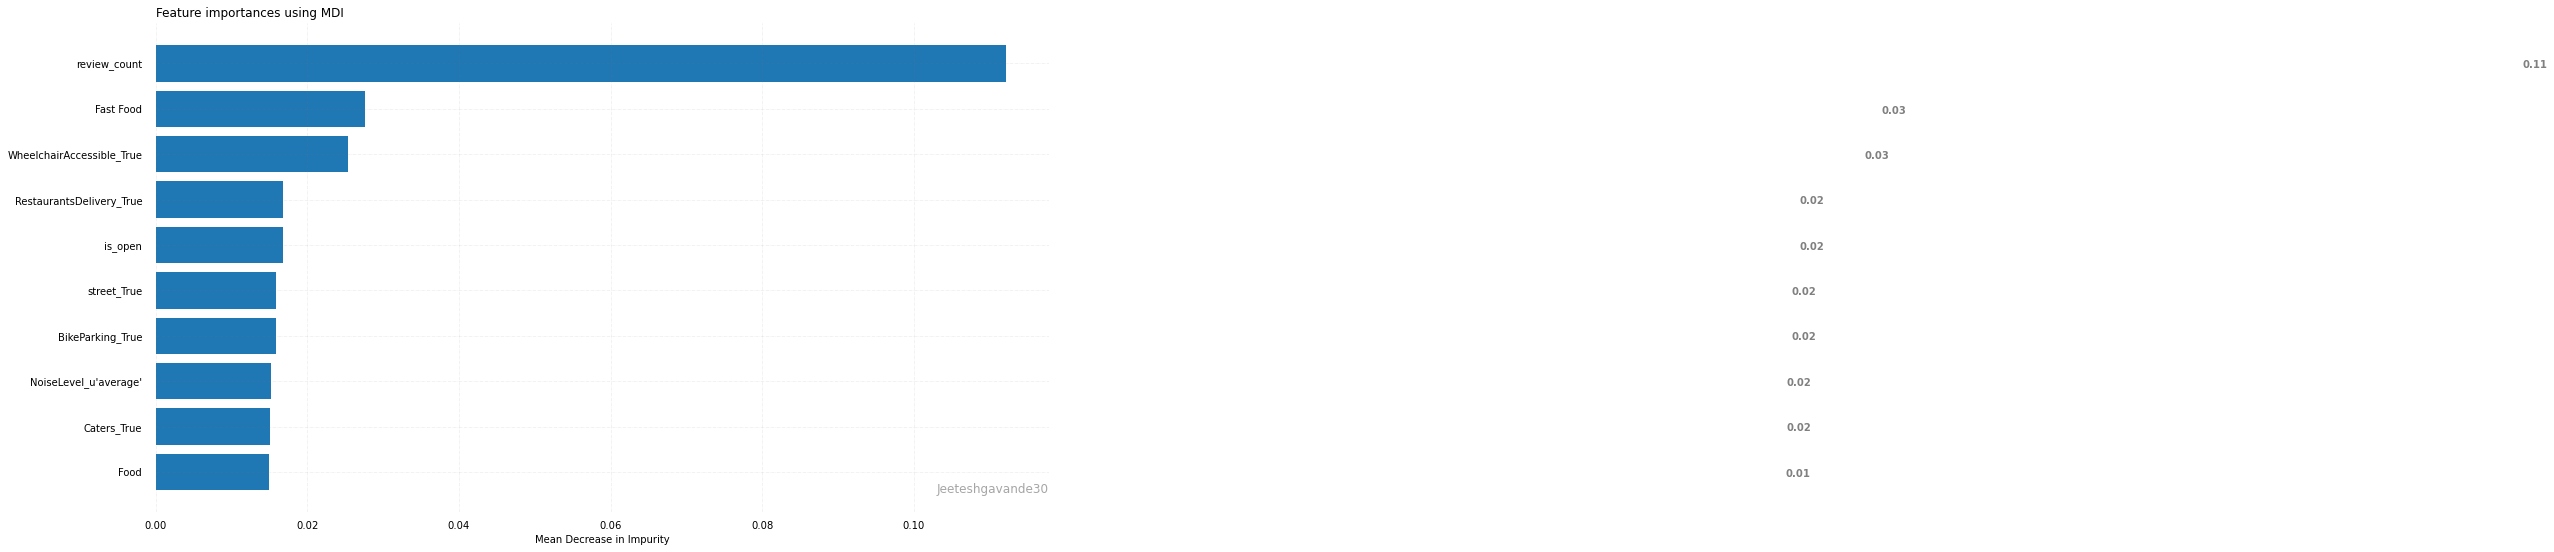

In [11]:
#Random Forests

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

clf = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid, random_state=42, n_iter = 50,
                          cv = 5, n_jobs = n_cpu-1, verbose = 2)
grid_search.fit(xTrain, yTrain)
grid_search.best_params_
best_grid = grid_search.best_estimator_
yPred = best_grid.predict(xTest)
print(classification_report(yTest, yPred))

# clf = RandomForestClassifier()
# clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = n_cpu-1)
# clf_random.fit(xTrain, yTrain)
# print(clf_random.best_params_)



# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# clf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                           cv = 3, n_jobs = n_cpu-1, verbose = 2)
# grid_search.fit(xTrain, yTrain)
# grid_search.best_params_
# best_grid = grid_search.best_estimator_
# yPred = best_grid.predict(xTest)
# print(classification_report(yTest, yPred))

# clf = RandomForestClassifier()
# clf.fit(xTrain, yTrain)
# yPred = clf.predict(xTest)
# print(classification_report(yTest, yPred))

# importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# forest_importances = pd.Series(importances, index=x.columns).nlargest(10)
# print(forest_importances)

# # Figure size
# fig, ax = plt.subplots(figsize=(16,9))

# # horizontal bar plot
# ax.barh(forest_importances.index, forest_importances.values)

# # remove axes splines
# for s in ['top', 'bottom', 'left', 'right']:
#     ax.spines[s].set_visible(False)
    
# # Remove x, y Ticks
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')

# # Add padding between axes and labels
# ax.xaxis.set_tick_params(pad = 5)
# ax.yaxis.set_tick_params(pad = 10)


# # Add x, y gridlines
# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)
 
# # Show top values
# ax.invert_yaxis()
 
# # Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey') 

# # add Plot Title
# ax.set_title('Feature importances using MDI', loc ='left', )

# ax.set_xlabel("Mean Decrease in Impurity")
 
# # Add Text watermark
# fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
#          color ='grey', ha ='right', va ='bottom',
#          alpha = 0.7)
 
# Show Plot
# plt.show()

# print("accuracy: ", accuracy_score(yTest, yPred))
# print("f1: ", f1_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

In [13]:
#pearson correlation
def pearson_corr(x, y):
    x['label'] = y
    xcorr = x.corr().abs()
    #setting up matplotlib
    f, ax = plt.subplots(figsize=(25,25))

    #generating mask
    mask = np.triu(np.ones_like(xcorr, dtype=bool))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(xcorr, annot=True, mask=mask, cmap=cmap)
    plt.savefig("Corr_Heatmap.png")

    #selecting best features
    bestfeatures = SelectKBest(k=5)
    fit=bestfeatures.fit(x, y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']